# Capstone Project - IEEE Fraud Detection

In my final Capstone project for the Udacity Data Scientist Nanodegree I will be analysing a dataset from [Kaggle](www.kaggle.com). I have decided to use a dataset from this website as it hosts a wide variety of datasets that are freely available. These datasets often are accompanied by competitions, where entrants can try their hand at tackling a data science problem on the dataset and get the best score, however this is evaluated.

## Project overview

My day job is as an analyst at a cyber security company. On a daily basis I deal with large transactional datasets and attempt to find the fraudulent transactions. With this background in mind, I decided that the [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) data set and competition would be a great candidate for me to analyse and attempt to build a good model for.

We are given a dataset of e-commerce transactions, i.e. online payments. The response variable is `isFraud`, which is a binary indicating whether the given transaction was found to be fraudulent. We have many columns, some categorical, some numerical, some boolean, indicating many different aspects of the transaction. As well, we are able to join to identifying information on the customer themselves. The datasets are listed below:

* *train_transaction.csv*: The section of the transactional dataset allocated for training
* *train_identity.csv*: The consumer identity data that applies to the train transaction dataset
* *test_transaction.csv*: The section of the transactional dataset allocated for testing and evaluation
* *test_identity.csv*: The consumer identity data that applies to the test transaction dataset

The aim of this competition, and by extension one of the aims of this project, is to produce a model that, when applied to the test dataset, performs very highly. The model will be evaluated using the Area Under the Curve (AUC) method, so we will use this approach when practicing with our training data.

This project will also encompass the preliminary data exploration and analysis of this dataset, as well as the approaches and algorithms used when applying the model. Hyper-parameter tuning will be explored. Finally, we will "deploy" the model test results onto Kaggle and discuss the score, results and potential improvements.

## Problem statement

The problem we are trying to solve is a binary classification problem on the `isFraud` variable. We are able to use the training dataset to evaluate our method using the AUC method. We will run the model on the test data and Kaggle will evaluate the model performance using the same method.

In other words, we are attempting to predict fraudulent transactions.

## Metrics

Firstly, every binary classification model has a value that is either "positive" or "negative". The positive value in our problem would be a value of 1 for `isFraud`. The negative would be a value of 0 for `isFraud`.

We can then evaluate whether the given value that we predicted by our model for `isFraud` is correct or not.

* True positive: predicted fraudulent and is actually fraudulent
* True negative: predicted not fraudulent and is not actually fraudulent
* False positive: predicted fraudulent and is not actually fraudulent
* False negative: predicted not fraudulent and is actually fraudulent

Being able to predict fraud relies on minimising false positives and false negatives, or maximising true positives and true negatives.

Further to this, we have the notions of:

* True Positive Rate (a.k.a. recall): TP / (TP + FN)
* False Positive Rate: FP / (FP + TN)

An ROC curve plots these two things at different classification thresholds [1]. We will compute the area under this curve in order to evaluate the performance of the model. This will allow us to maximize true positives while minimizing false positives.

The Area Under the Curve (AUC) approach will be used to evaluate the model performance.

## Data Exploration

We have the response variable `isFraud` which is a binary value, only present in the training data.

In [ ]:
import numpy as np
import pandas as pd

id = pd.read_csv('../input/train_identity.csv')
tr = pd.read_csv('../input/train_transaction.csv')

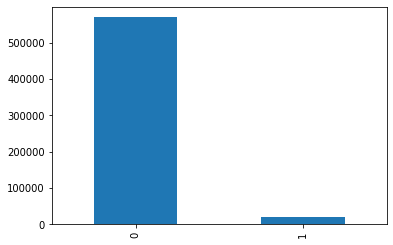

In [6]:
tr.isFraud.value_counts().plot.bar()

This is a clearly highly imbalanced variable, as only 20,663 transactions are marked fraudulent compared with 596,877 non-fraudulent transactions. The classes should be made to be roughly equal size. This could lead to a poorly performing model if not corrected.

There is also a challenge in that the identity data is stored separately from the transactional data. We should look at both of these datasets when tuning and running the model.

### Categoricals

We are told that the following variables are categorical from the transactional dataset:
    
* `ProductCD`
* `card1` - `card6`
* `addr1`, `addr2`
* `P_emaildomain`
* `R_emaildomain`
* `M1` - `M9`

Also, the identity dataset has the following categorical variables:
    
* `DeviceType`
* `DeviceInfo`
* `id_12` - `id_38`

Since we need to run the model using numerical values, we should encode the categoricals into numeric ones somehow. Let's look into the `card4` variable for example.

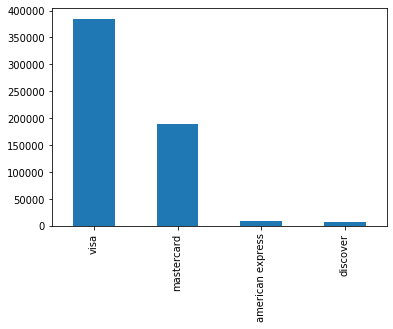

In [10]:
tr.card4.value_counts().plot.bar()

This variable appears to describe the operator of the card used. There are 2 main ones: Mastercard and Visa, but it's also interesting to include American Express and Discover.

The `DeviceType` column is even simpler.

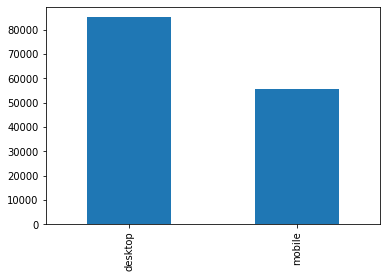

In [12]:
id.DeviceType.value_counts().plot.bar()

This gives the platform type that was used for the transactions, with a pretty even split between desktop and mobile. This will require minimal preprocessing.

Some categorical features have a very high cardinality, and may not be so useful to us due to the potential for overfitting.

In [17]:
len(tr.card1.unique())

13553

The `card1` variable is an example of this. There are 13,553 distinct values. It may not be feasible to encode all of these.

There are other categorical features that are somewhere in the middle between low and high cardinality. One example would be the `DeviceInfo` feature of the identity dataset.

In [32]:
id.DeviceInfo.value_counts().head(10)

Windows                  47722
iOS Device               19782
MacOS                    12573
Trident/7.0               7440
rv:11.0                   1901
rv:57.0                    962
SM-J700M Build/MMB29K      549
SM-G610M Build/MMB29K      461
SM-G531H Build/LMY48B      410
rv:59.0                    362
Name: DeviceInfo, dtype: int64

This looks to be the user agent string or some portion of it containing mainly platform information but with some device identifying characteristics as well, e.g. the `Build/MMB29K` portion of the `SM-J700M Build/MMB29K` string.

We may need to modify this feature in order to group together some of these values into meaningful groups.

### Numericals

There are many columns that describe numerical values. Let's start with the `TransactionAmt` column, which describes the dollar amount spent in the transaction.

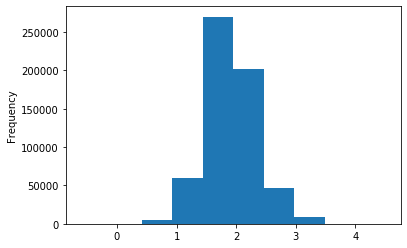

In [19]:
np.log10(tr.TransactionAmt).plot.hist()

It made sense to plot a histogram of the logarithm of the price, since most transactions are between 1 and 1000. The few extreme transactions that are above this are affecting the visualisation when using a linear scale. These transactions are also interesting to include since they are monetary and hence large amounts are significant and carry a great deal of meaning.

In [24]:
tr.V2.value_counts()

1.0    298894
2.0     10926
3.0      1181
4.0       163
5.0        36
6.0        30
0.0        20
7.0         2
8.0         1
Name: V2, dtype: int64

The `V2` column among others appears to be ordinal, consisting of a discrete numerical whole number value that appears to have some order attached to it. Other `V_` columns display this characteristic. It might make sense to consider these as-is.

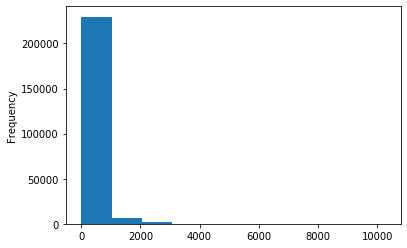

In [27]:
tr.dist1.plot.hist()

As with `TransactionAmt` the `dist1` variable appears to have a small number of extreme values, which skews the histogram when plotting linearly. This variable appears to represent some geographical distance, perhaps some distance between IP and vendor. We would like to include extreme values, since we are looking for anomalous behaviour.

### Time-based

We also have the `TransactionDT` column, which although numerical is actually time-based, since it denotes the number of seconds from some reference datetime. We cannot simply deal with variable this as-is, since we want to predict future fraud as well as current. If we know that fraud happened in February 2018, we can't use that knowledge alone to predict fraud in June 2020. We will need to use ways to extract elements of the time information that are potentially repeatable for future time periods.

### Nulls

In [29]:
tr.M4.isnull().value_counts()

False    309096
True     281444
Name: M4, dtype: int64

We are also seeing many variables with a high number of missing values, such as `M4` shown above. We will need an imputation strategy for these.

## Methodology

### Initial steps

The `data/process_data.py` file performs the basic preprocessing steps on the data:

1. Read the transaction and identity data from the .csv files.
2. Merge the datasets using the `TransactionID` column - we will take a left join on the identity dataset because the `TransactionID` values in the identity dataset are a subset of those found in the transaction dataset.
3. Save the data into a local sqlite database.

This file is run on the training dataset initially, but when we want to evaluate the results on the test dataset, we will run this on the test too.

Running on `train_transaction.csv` and `train_identity.csv`, we produce a file `train_transactions.db`. This will be used by the `models/train_classifier.py` file to perform more preprocessing and train the model, as seen in `load_data`.

### Medium cardinality categoricals

Let's group together some of the values in `DeviceInfo`. In `train_classifier.py` we have a dict `col_dict` which contains as keys the lower case substrings that we are looking for in `DeviceInfo`. The values are the formatted version of the keys.

```python
col_dict = {
    'win': 'Windows',
    'mac': 'Mac',
    'samsung': 'Samsung',
    'sm-': 'Samsung mobile',
    'trident': 'Trident',
    'huawei': 'Huawei',
    'ios': 'iOS',
    'lg': 'LG',
    'moto': 'Moto',
    'rv': 'rv',
    'redmi': 'Redmi',
    'htc': 'HTC',
    'gt-': 'GT',
    'hisense': 'Hisense',
    'blade': 'Blade',
    'alcatel': 'Alcatel',
    'linux': 'Linux',
    'nexus': 'Nexus',
    'asus': 'Asus'
}
```

We then have the function `regex_replace` which searches using regex for each of the keys within a given `text` string. On matching the relevant `col_dict` value is returned:

```python
def regex_replace(col_dict, text):
    regex = re.compile("(%s)" % "|".join(
        map(re.escape, col_dict.keys())
    ), re.IGNORECASE)
    if regex.search(text):
        ret = regex.search(text)
        return col_dict[ret.group().lower()]
    else:
        return 'Other'
```

Note that on a no match we return 'Other'.

This is then applied to the dataset in `preprocess_data` with the following line:

```python
X['DevicePlatform'] = X['DeviceInfo'].apply(lambda v: regex_replace(col_dict, str(v)))
```

### Date time components

It was noted previously that the `TransactionDT` column is not usable in its current state because it is not time independent. We want to extract elements of the time that are repeatable.

Examples of such repeatable time elements are things like the hour of the day (0-23), day of the week (0-6) or day of the month (~0-30). Since the `TransactionDT` column is seconds since some unknown reference date, we do not know strictly how to compute this. It does not really matter though.

Below is code from `preprocess_data` that firstly extracts assumed absolute time values: minutes, hours, days, weeks, months and years. From this, approximations are given to find the day of week, the day of month and the hour of day metrics. These 3 metrics will be used as features.

```python
# Encode time based variables
X['mins'] = np.floor(X.TransactionDT / 60)
X['hours'] = np.floor(X['mins'] / 60)
X['days'] = np.floor(X['hours'] / 24)
X['weeks'] = np.floor(X['days'] / 7)
X['months'] = np.floor(X['days'] / 365 * 12)
X['years'] = np.floor(X['days'] / 365)

X['dayofweek'] = np.mod(X['days'] - X['weeks'] * 7, 7)
X['dayofmonth'] = np.floor(np.mod(X['days'] - np.floor(X['months'] * 365 / 12), 365 / 12))

X['hourofday'] = np.mod(X['hours'] - X['days'] * 24, 24)
```

### Initial imputation

There is an issue with `NaN` values appearing in the dataset. In order to perform the resampling (the next step), I have initially filled in the affected columns with a string value `'NaN'` in the `preprocess_data` function. These will later be dealt with on a feature by feature basis during the model Pipeline.

### Resampling

The next issue we will tackle is the imbalanced nature of the response variable `isFraud`. As previously discussed, we have just 3% of the records being flagged as fraudulent. To combat this, we will perform random undersampling of the target data.

The code below is `resample_data` contained within `models/train_classifier.py`.

```python
from imblearn.under_sampling import RandomUnderSampler

def resample_data(X, y, cols=None):
    """
    Preprocess and resample the data to balance out the classes
    :param X: Features dataset
    :param y: Response dataset
    :return: Resampled X and y
    """
    
    if cols is None:
        cols = X.columns

    rus = RandomUnderSampler()
    X_rs, y_rs = rus.fit_sample(X[cols], y)

    return X_rs, y_rs
```

When run on the features dataset `X` and the response variable `y`, with optionally provided columns to resample over from X, the random undersampling will be performed, returning `X_rs` and `y_rs` which have classes balanced in `y` approximately equally.

Random undersampling randomly reduces the sizes of the larger classes until the classes have the same size as the smallest class.

### Wrapper for importing data

I have built a function `import_data` that takes care of applying all the preprocessing steps to the intial database file (already run through `process_data.py`. It applies the above transformations and then saves the output dataset locally, so that the preprocessing does not have to be performed again. This is useful to save time on rerunning and iterating the model on the training data, and for applying the same preprocessing steps to the test data.

### One hot encoding categoricals

We need to convert the categorical variables into a numerical form. One very simple way to do this is to one-hot encode them, i.e. create a column for each class with 1 when that value is set and 0 otherwise.

I have applied this to all considered categorical variables, through use of sklearn's `OneHotEncoder` function within my `build_model` function as follows:

```python
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

from ieee_fraud_detection.models.selection_functions import *

onehot = ('onehot_encoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))

## CATEGORICALS
pipe_ProductCD = Pipeline([
    ('column_selection', FunctionTransformer(col_ProductCD, validate=False)),
    onehot
])
pipe_card4 = Pipeline([
    ('column_selection', FunctionTransformer(col_card4, validate=False)),
    onehot
])
...
pipe_dayofmonth = Pipeline([
    ('column_selection', FunctionTransformer(col_dayofmonth, validate=False)),
    onehot
])
```

From experimentation it seemed as though applying this to all categoricals considered was giving reasonable results, so other approaches were not considered.


### Pipeline-ing

At this point it's good to note that I am containing the model within a sklearn `Pipeline`. This makes it simple to save and re-use the model later once trained. It also clarifies the process used.

Note, I am making a sub-`Pipeline` for every feature considered, which are then combined into a larger `Pipeline` using the `FeatureUnion` function. 

The final step is to run the model through the classifier, which in the code is given as `('clf', RandomForestClassifier())`. There is a much deeper discussion about this later on.

Note that I have created column selection helper functions in `ieee_fraud_detection.models.selection_functions`.

### Log-scale some numericals

During the data exploration it was noted that `TransactionAmt` and `dist1` were heavily skewed. These could benefit from a log transformation. 

In `models/selection_functions.py` we have the functions `col_TransactionAmt` and `col_dist1` which apply a log10 transformation to the variables in order to select them for the `Pipeline`.

```python
def col_TransactionAmt(X):
    return np.log10(X[['TransactionAmt']])

def col_dist1(X):
    return np.log10(X[['dist1']].astype(float) + 1).fillna('NaN')
```

Note, we are also filling any missing values temporarily with `'Nan'`.

### Imputation for numericals

For every numerical feature, we are applying an imputation step to address the nulls. For most of the numerical features with missing values, we impute the most frequent value:

```python
from sklearn.impute import SimpleImputer

imputer_most_frequent = ('imputer', SimpleImputer(missing_values='NaN', strategy='most_frequent'))

pipe_V2 = Pipeline([
    ('column_selection', FunctionTransformer(col_V2, validate=False)),
    imputer_most_frequent
])
```

This works especially well for ordinal features such as `V2`, since these take only discrete whole number values.

There are two float columns: `dist1` and `dist2`. We impute a constant value of zero for these columns:

```python
imputer_constant = ('imputer', SimpleImputer(missing_values='NaN', strategy='constant', fill_value=0))

pipe_dist1 = Pipeline([
    ('column_selection', FunctionTransformer(col_dist1, validate=False)),
    imputer_constant
])

pipe_dist2 = Pipeline([
    ('column_selection', FunctionTransformer(col_dist2, validate=False)),
    imputer_constant
])
```

### Null boolean columns

Finally, we create boolean columns evaluating whether a column is null:

```python
def col_V1NaN(X):
    return X[['V1']] == 'NaN'

pipe_V1NaN = Pipeline([
    ('column_selection', FunctionTransformer(col_V1NaN, validate=False))
])
```

This is performed for all numerical features that have missing values. We do not need to perform this for the categorical features, since one-hot encoding will already take care of nulls implicitly.


### Train-test split

In the `main` function, each of the steps are called to run through the training process. After the data is imported, we create a split into test and train using the `train_test_split` function.

```python
print('Creating train test split from data...')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
```

Note, this is a further subdivision of the original training dataset into train and test, since we do not have the `isFraud` values for validation in the original test dataset.

Early on when validating model results, I found that a `test_size` of 0.2 was producing a good score, so I left it at this value.


### Choice of algorithm

I initially tested classification using the `GaussianNB` classifier. I found this to be very easy to set up from a coding perspective since there are very few tunable parameters, and the model trains very quickly. It was helpful to have this algorithm there while building out the code for the feature selection as I could rapidly test whether the feature transformation was somewhat helpful to the overall score. This guided me towards my final choice of features.

I quickly realised that other algorithms had greater success. I tried out `RandomForestClassifier`, `AdaBoostClassifier` and `ExtraTreesClassifier` with default parameters and found that the random forest classifier was the most successful with the existing set up that I had.

I then set about performing hyper-parameter tuning on `RandomForestClassifier`.


### Grid search and parameter grid

The sklearn `Pipeline` framework provides a nice easy way to perform hyper-parameter tuning. 

I have utilized the `GridSearchCV` function to perform a grid search on the model parameters, while also performing a 10-fold cross validation. 

```python
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ...
])

# Set up a parameter grid
pg = [
    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [10],
        'clf__criterion': ['entropy'], # ['gini', 'entropy'],
        'clf__min_samples_split': [10], # [10,20,50,100],
        'clf__min_samples_leaf': [1], # [1,2,5,10],
        'clf__min_weight_fraction_leaf': [0], # [0, 0.01, 0.1, 0.5],
        'clf__max_features': [None], # ['auto', 'sqrt', 'log2', None],
        'clf__bootstrap': [True], # [True, False],
        'clf__oob_score': [False], # [False, True],
    }
]

GridSearchCV(
    pipe, param_grid=pg, cv=10, scoring='roc_auc'
)
```

The `'roc_auc'` scoring parameter is used to reflect the AUC scoring criterion for this project.

When building out the parameter grid, I let it run for a long time with many iterations across all the parameters. The values iterated over are commented out. The optimal values are kept in.

### Model evaluator

The `evaluate_model` function takes the trained model as well as the test features and response datasets and prints out several methods to evaluate the performance of the model.

Firstly, the predicted output is gleaned from the model when applied to the test features:

```python
# Predict the output of the model on the test data
y_pred = model.predict(X_test)
```

Next, we use the `metrics` library from sklearn to display the following attributes:

* Accuracy: (TP + TN) / Total
* Precision: TP / (TP + FP)
* Recall: TP / (TP + FN)
* F1 score: harmonic mean of precision and recall
* Confusion matrix

```python
from sklearn import metrics

print('Accuracy: {}\nPrecision: {}\nRecall: {}\n==============\n'.format(
    metrics.accuracy_score(y_test, y_pred),
    metrics.precision_score(y_test, y_pred),
    metrics.recall_score(y_test, y_pred)
))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
```

We also extract the `best_score_` and `best_params_` attributes of our model, where score is computed as the ROC AUC:

```python
# Output the GridSearchCV best score and best params
print('The best score from GridSearchCV: {}'.format(model.best_score_))
print('Best model parameters:')
print(model.best_params_)
```

### Save the model

Finally the `save_model` function uses `pickle` to save the model to a local file.

## References

[1] Classification: ROC Curve and AUC | Machine Learning Crash Course https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc